In [1]:
## Where the data at?
input_path = '../Data/Processed_Data/Cell_Deconvolution/'
output_path = '../Data/Processed_Data/Cell_Deconvolution/'

In [2]:
score_name = 'ARIC_mC_score'

In [3]:
# Import libraries for data manipulation
import pandas as pd

y = pd.read_csv(input_path+'y_plus_cibersortx_ARICresults.csv', index_col=0)

# Split data into training and test sets by clinical trial
y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_train = y_train[y_train['os.time'].notnull()] # Remove patients with missing OS data
y_test = y[y['Clinical Trial'].isin(['AML02', 'AML08'])]

# Read deconvolution results files
deconv = pd.read_csv(output_path+'Results_TrainData_ARIC.csv', index_col=0).T
deconv = deconv.loc[y_train.index]
deconv_test = pd.read_csv(output_path+'Results_TestData_ARIC.csv', index_col=0).T

# Standardize dataset (z-scoring)
x_train = (deconv-deconv.mean())/deconv.std()
x_test = (deconv_test-deconv_test.mean())/deconv_test.std()


In [4]:
from FM_Functions.Cox_Lasso_Function import *

# raw_coefs = train_coxph_lasso(df=y_train,
#                                 event= 'os.evnt',
#                                 time= 'os.time',
#                                 train_x=x_train,
#                                 loops=1000)

# raw_coefs.to_csv(output_path+'ARIC_mC_score_Raw_Coefs.csv')
raw_coefs = pd.read_csv(output_path+'ARIC_mC_score_Raw_Coefs.csv', index_col=0)

In [5]:
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.85)
mean_coefs                                    

cell types
NK        0.159844
Mono      0.019041
CD4mem    0.013240
Treg     -0.009372
CD8nv    -0.053785
Bmem     -0.071533
Eos      -0.083367
Bnv      -0.131912
dtype: float64

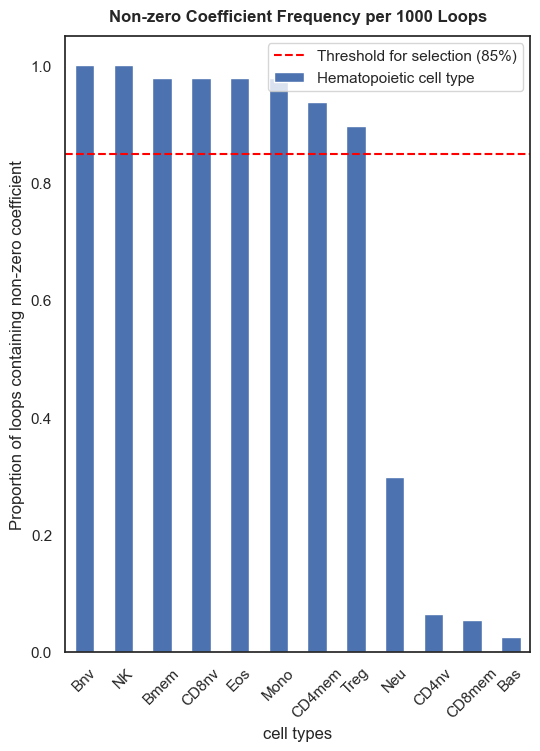

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

_, ax = plt.subplots(figsize=(6,8))
raw_coefs['nonzero_freq'].plot.bar(ax=ax, legend=False, label='Hematopoietic cell type')
plt.title('Non-zero Coefficient Frequency per 1000 Loops', fontweight='bold', y=1.01)
plt.axhline(0.85, linestyle="--", color="red", label="Threshold for selection (85%)")
# Adjust xtick labels
plt.xticks(rotation=45)
# add y label
plt.ylabel('Proportion of loops containing non-zero coefficient')
plt.legend()
plt.savefig('../Figures/Bar_Plots/'+score_name+' - Non-zero Coefficient Frequency per 1000 Loops', bbox_inches='tight', dpi=300)

In [7]:
y_train2, y_train_cutoff = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_train,
                                        df=y_train,
                                        score_name=score_name,
                                        train_test="train",
                                        cutoff_train=0.75)

Continuous score cut at the value of 0.1241


In [8]:
y_test2, _ = generate_coxph_score(coef_mean=mean_coefs,
                                            x=x_test,
                                            df=y_test,
                                            score_name=score_name,
                                            train_test=y_train_cutoff,
                                            cutoff_train=None)

Continuous score cut at the value of 0.1241


In [9]:
y_train2.to_csv(input_path+'y_plus_cibersortx_ARICresults_'+ score_name +'.csv')
y_test2.to_csv(input_path+'y_plus_cibersortx_ARICresults_'+ score_name +'_test.csv')